## Подготовка.

In [1]:
import numpy as np
import pandas as pd

from math import log, sqrt, pi, exp
from scipy.stats import norm

from CONSTANTS import EXP_DATES

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
TARGET_COLUMN_NAME = 'adjp'

In [4]:
class Jarvis:
    """
    Jarvis class for fun and profit.
    
    This class contains some data management, futures and options analisys features.
    Backtesting is planned.
    """
    
    def __init__(self, name):
        
        #-----init_constants:
        self.N_STRIKES = 8
        self.FUTCODES_AND_STRIKESTEPS = {
            'RTS': 2500,
            'Si': 500
        }
        self.MONEYNESS_STRIKES = {
            'minus_five' : -5, 'minus_four' : -4, 'minus_three' : -3, 'minus_two' : -2, 'minus_one' : -1,
            'center': 0,
            'plus_one' : +1, 'plus_two' : +2, 'plus_three' : +3, 'plus_four' : +4, 'plus_five' : +5
        }
        self.CALL_PUT = {'C' : 'call', 'P' : 'put'}
        self.PATH_WEB_1 = \
        'https://www.moex.com/ru/derivatives/contractresults-exp.aspx?day1=20000101&day2=20230316&code='
        self.PATH_WEB_2 = \
        'https://www.moex.com/ru/derivatives/contractresults-exp.aspx?type=2&day1=20000101&day2=20230316&code='
        self.PATH_LOCAL_FUTURES = 'FUTURES/'
        self.PATH_LOCAL_OPTIONS = 'OPTIONS/'
        self.COLUMNS = ['date', 'wavp', 'adjp', 'open', 'high', 'low', 'close', 'chng', 'lt_vol', 
                        'n_trades', 'vol_rub', 'vol_contr', 'oi_rub', 'oi_contr']
        self.TARGET_COLUMN = TARGET_COLUMN_NAME
        
        #-----init_variables:
        self.name = name
        split_ = self.name.split('-')
        self.key = split_[0]
        self.date = split_[1]
        self.strike_step = self.FUTCODES_AND_STRIKESTEPS[self.key]
        self.parse_fut_log, self.data = self.fut()
        self.exp_date = EXP_DATES[self.date]['qrt'][0]
        self.qrt_opt_parse_log, self.qrt_opt = self.opt()
        self.vola_log, self.vola_df = self.center_strike()

    #-----B.-Sh. formulae implementation:
    def d1_calc(self, spot, strike, sigma, T):
        result = (log(spot/strike) + 0.5 * (sigma ** 2) * (T)) / (sigma * sqrt(T))
        return result

    def n_d1_calc(self, d1):
        result = (1 / sqrt(2 * pi)) * exp(-0.5 * (d1 ** 2))
        return result

    def price(self, spot, strike, sigma, T, option_type):
        d1 = self.d1_calc(spot, strike, sigma, T)
        d2 = d1 - sigma * sqrt(T)
        if option_type == 'call':
            N_d2 = norm.cdf(d2)
            delta_call = norm.cdf(d1)
            result = (spot * delta_call - strike * N_d2)
        if option_type == 'put':
            N_minus_d2 = norm.cdf(-d2)
            delta_put = (norm.cdf(d1) - 1)
            result = (strike * N_minus_d2 + spot * delta_put)
        return result

    def delta(self, spot, strike, sigma, T, option_type):
        d1 = self.d1_calc(spot, strike, sigma, T)
        delta_call = norm.cdf(d1)
        if option_type == 'call':
            result = delta_call
        if option_type == 'put':
            result = (delta_call - 1)
        return result

    def gamma(self, spot, strike, sigma, T):
        d1 = self.d1_calc(spot, strike, sigma, T)
        n_d1 = self.n_d1_calc(d1)
        result = n_d1 / (sigma * spot * sqrt(T))
        return result

    def theta(self, spot, strike, sigma, T):
        d1 = self.d1_calc(spot, strike, sigma, T)
        n_d1 = self.n_d1_calc(d1)
        result = (-spot * n_d1 * sigma / (2 * sqrt(T))) / 365
        return result

    def vega(self, spot, strike, sigma, T):
        d1 = self.d1_calc(spot, strike, sigma, T)
        n_d1 = self.n_d1_calc(d1)
        result = spot * sqrt(T) * n_d1 / 100
        return result

    #-----implied_volatility_iteration:
    def loss_func(self, spot, strike, T, option_type, sigma, premium):
        "Ф-ия потерь: в данном случае сравнением расчетной премии с фактической."
        return self.price(spot, strike, sigma, T, option_type) - premium

    def compute_iv(self, spot, strike, T, option_type, premium):
        "Функция итеративного поиска значения подразумеваемой волатильности."
        left = 0.01
        right = 10
        error = 0.0000001
        while right - left > error:
            if self.loss_func(spot, strike, T, option_type, left, premium) == 0:
                return left
            middle = (left + right) / 2
            if self.loss_func(spot, strike, T, option_type, left, premium) * \
            self.loss_func(spot, strike, T, option_type, middle, premium) < 0:
                right = middle
            else:
                left = middle
        return left

    #-----расчет подразумеваемых волатильностей для фактических значений текущих датафреймов
    def get_ivs(self, row):
        prem = row['center_prem']
        if np.isnan(prem):
            return np.NaN
        T = row['T']
        if T == 0:
            return np.NaN
        spot = row['spot']
        if np.isnan(spot):
            return np.NaN
        center = row['center']
        if np.isnan(center):
            return np.NaN
        try:
            x = self.compute_iv(spot, center, T, 'call', prem) * 100
        except:
            x = np.NaN
        return x
    
    def get_premium(self, row):
        date = row.name
        try:
            x = self.qrt_opt[(self.qrt_opt.index == date) &
                           (self.qrt_opt['strike'] == row['center']) &
                           (self.qrt_opt['option_type'] == 'call')][self.TARGET_COLUMN][0]
        except:
            x = np.NaN
        return x

    def center_strike(self):
        vola_log = {}
        vola_df = pd.DataFrame(index = self.data.index)
        vola_df['T'] = ((pd.to_datetime(self.exp_date, format = '%d%m%y') - vola_df.index).days / 365)
        vola_df['spot'] = self.data[self.TARGET_COLUMN]
        vola_df['center'] = round(vola_df['spot'] / self.strike_step) * self.strike_step
        vola_df['center_prem'] = vola_df.apply(self.get_premium, axis = 1)
        vola_df['center_iv'] = vola_df.apply(self.get_ivs, axis = 1)
        #vola_df = vola_df.dropna()
        return vola_log, vola_df
    
    #-----ниже блок загрузки цсв файлов
    def parse_csv(self, name, parse_from, datetime_format):
        "Парсим цсв (внезапно)."
        x = pd.DataFrame()
        result = {}
        result['name'] = name
        try:
            x = pd.read_csv(parse_from, encoding='cp866')
            try:
                x.columns = self.COLUMNS
                result['columns'] = True
            except:
                result['columns'] = False
            try:
                x['date'] = pd.to_datetime(x['date'], format = datetime_format)
                result['to_datetime'] = True
            except:
                result['to_datetime'] = False
            try:
                x = x.sort_values(by = 'date')
                result['sort_values'] = True
            except:
                result['sort_values'] = False
            try:
                x.set_index('date', inplace = True)
                result['set_index'] = True
            except:
                result['set_index'] = False
            result['read_scv'] = True
        except:
            result['read_scv'] = False
        return result, x

    def local(self, name, path):
        "Качаем дату с локальной папки (по умолчанию)."
        parse_from = (path + self.key + '/' + name + '.csv')
        datetime_format = '%Y.%m.%d'
        result, x = self.parse_csv(name, parse_from, datetime_format)
        return result, x

    def web(self, name, path):
        "Качаем дату с сайта."
        parse_from = (self.PATH_WEB_1 + name)
        datetime_format = '%d.%m.%Y'
        result, x = self.parse_csv(name, parse_from, datetime_format)
        if result['read_scv']:
            try:
                x.to_csv(path + self.key + '/' + name + '.csv')
            except:
                print(name, 'no save')
        return result, x

    def parse(self, name):
        """
        argument name as follows: RTS-3.23, RTS-3.23M150922CA100000 (no .csv extension)
        """
        if len(name) > 10:
            path = self.PATH_LOCAL_OPTIONS
        else:
            path = self.PATH_LOCAL_FUTURES
        result, x = self.local(name, path)
        result['parse_local'] = True
        if result['read_scv'] == False:
            result, x = self.web(name, path)
            result['parse_local'] = False
        try:
            x = x[[self.TARGET_COLUMN]]
            result['set_t_col'] = True
        except:
            result['set_t_col'] = False
        return result, x
    
    #-----качаем фьючерс
    def fut(self):
        name = self.name
        result, x = self.parse(name)
        result = pd.DataFrame([result])
        return result, x

    #-----добавляем опционы на фьючерс        
    def opt(self):
        lower = round(self.data[self.TARGET_COLUMN].min() / self.strike_step) * self.strike_step
        upper = round(self.data[self.TARGET_COLUMN].max() / self.strike_step) * self.strike_step
        results = []
        options_df = pd.DataFrame()
        for strike in range(lower - self.N_STRIKES * self.strike_step, upper + (self.N_STRIKES + 1) \
                            * self.strike_step, self.strike_step):
            for call_put in self.CALL_PUT:
                name = self.name + 'M' + self.exp_date + call_put + 'A' + str(strike)
                result, data = self.parse(name)
                if result['read_scv'] == False:
                    name = self.name + 'M' + self.exp_date + call_put + 'A' + '%20' + str(strike)
                    result, data = self.parse(name)
                try:
                    data['strike'] = strike
                    result['strike'] = True
                except:
                    result['strike'] = False
                try:
                    data['option_type'] = self.CALL_PUT[call_put]
                    result['option_type'] = True
                except:
                    result['option_type'] = False
                results.append(result)
                options_df = pd.concat([options_df, data])
        try:
            options_df = options_df.sort_values(by = ['date', 'strike', 'option_type'])
        except:
            pass
        results = pd.DataFrame(results)
        results = results.fillna(0)
        return results, options_df
        
    #-----ниже накладываем фичи на датафрейм фьючерса
    def calc_rv(self, shift = 1):
        """
        Накладываем фичи реализованной волатильности.
        
        В целях предсказания делаем сдвиг фичей:
        """
        self.data['return'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change() + 1
        self.data['return_5'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 5) + 1
        self.data['return_10'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 10) + 1
        self.data['return_20'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 20) + 1
        self.data['return_40'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 40) + 1
        self.data['return_60'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 60) + 1
        self.data['ln_r'] = np.log(self.data['return'])
        self.data['volatility_5'] = self.data['ln_r'].rolling(5).std(ddof = 1) * 100 * np.sqrt(260)
        self.data['volatility_20'] = self.data['ln_r'].rolling(20).std(ddof = 1) * 100 * np.sqrt(260)
        self.data['volatility_60'] = self.data['ln_r'].rolling(60).std(ddof = 1) * 100 * np.sqrt(260)

    def movings(self, n = 5, shift = 1):
        """
        Накладываем мувинги датафрейм.
        
        Параметры:
        n - период усреднения, обязательный параметр, по умолчанию равен пяти.
        shift - сдвиг назад: в целях расечта предсказательных моделей необходимо добовалять в целях
                предотвращения утечки целевого признака, в обзорных целях нагляднее не применять сдвиг.
                по умолчанию сдвиг равен единице.
        """
        self.data['mov_{}'.format(n)] = self.data[self.TARGET_COLUMN].shift(shift).rolling(n).mean()
            
    def lags(self):
        """
        Эта функция накладывает лаги цены.
        """
        self.data['lag_1'] = self.data[self.TARGET_COLUMN].shift(1)
        self.data['lag_2'] = self.data[self.TARGET_COLUMN].shift(2)
        self.data['lag_3'] = self.data[self.TARGET_COLUMN].shift(3)
        self.data['lag_5'] = self.data[self.TARGET_COLUMN].shift(5)
        self.data['lag_10'] = self.data[self.TARGET_COLUMN].shift(10)
        self.data['lag_20'] = self.data[self.TARGET_COLUMN].shift(20)
        self.data['lag_40'] = self.data[self.TARGET_COLUMN].shift(40)
        self.data['lag_60'] = self.data[self.TARGET_COLUMN].shift(60)

    def diffs(self):
        """
        Эта функция накладывает разницу цены.
        """
        self.data['dif_1'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(1)
        self.data['dif_2'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(2)
        self.data['dif_3'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(3)
        self.data['dif_5'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(5)
        self.data['dif_10'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(10)
        self.data['dif_20'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(20)
        self.data['dif_40'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(40)
        self.data['dif_60'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(60)

    def calendar_features(self):
        """
        Эта функция накладывает календарные фичи.
        """
        # константа и тренд
        self.data['const'] = np.ones(self.data.shape[0])
        self.data['time_step'] = np.arange(len(self.data.index))
        # сезонность
        self.data['year'] = self.data.index.year
        self.data['month'] = self.data.index.month
        self.data['day'] = self.data.index.day
        self.data['day_of_week'] = self.data.index.dayofweek
        self.data['sin_month'] = np.sin(2 * np.pi * self.data.index.month / 12)
        self.data['cos_month'] = np.cos(2 * np.pi * self.data.index.month / 12)
        self.data['sin_day'] = np.sin(2 * np.pi * self.data.index.day / (365/12))
        self.data['cos_day'] = np.cos(2 * np.pi * self.data.index.day / (365/12))
        self.data['sin_dw'] = np.sin(2 * np.pi * self.data.index.dayofweek / 4)
        self.data['cos_dw'] = np.cos(2 * np.pi * self.data.index.dayofweek / 4)

    #-----сводное инфо по классу
    def info(self):
        try:
            print('Name:', self.name)
            print()
        except:
            pass
        print('Fut info:')
        try:
            print('Parse_log:')
            display(self.parse_fut_log)
            print()
        except:
            pass
        print('Head:')
        display(self.data.head())
        print()
        print('Tail:')
        display(self.data.tail())
        print()
        print('Info:')
        print(self.data.info())
        print()
        print('Missings:')
        print(self.data.isna().sum().sort_values(ascending = False))
        print()
        print('Monotonic:')
        print(self.data.index.is_monotonic)
        print()
        print('Describe:')
        display(self.data.describe())
        
        print('Opt info:')
        try:
            print('Parse_log:')
            display(self.qrt_opt_parse_log)
            print()
        except:
            pass
        print('Opt parse log:')
        print(self.qrt_opt_parse_log.mean())
        print('Head:')
        display(self.qrt_opt.head())
        print()
        print('Tail:')
        display(self.qrt_opt.tail())
        print()
        print('Info:')
        print(self.qrt_opt.info())
        print()
        print('Missings:')
        print(self.qrt_opt.isna().sum().sort_values(ascending = False))
        print()
        print('Monotonic:')
        print(self.qrt_opt.index.is_monotonic)
        print()
        print('Describe:')
        display(self.qrt_opt.describe())
        print('-----')
        
# d:^{|

In [5]:
class Vision:
    def __init__(self, name_):
        self.TARGET = TARGET_COLUMN_NAME
        self.MONTHS = ['3', '6', '9', '12']
        self.YEARS = ['20', '21']
        self.names_list = []
        self.objects_dict = {}
        self.name = name_
        #-----let's fill dict with J. objects
        for year in self.YEARS:
            for month in self.MONTHS:
                name = self.name + '-' + str(month) + '.' + str(year)
                self.names_list.append(name)
                self.objects_dict[name] = Jarvis(name)
                
    #-----we need some methods for most common analysis patterns
    def plot(self, what_to_plot = 'fut', value = 'adjp'):
        start_date = '2000-01-01'
        if what_to_plot == 'fut':
            targets = pd.DataFrame()
            for name in self.names_list:
                object_ = self.objects_dict[name]
                target = object_.data[[value]]
                target = target[start_date:]
                start_date = str(target.index[target.shape[0]-1].year) + '-' + \
                str(target.index[target.shape[0]-1].month) + '-' + \
                str(target.index[target.shape[0]-1].day+1)
                targets = pd.concat([targets, target])
            targets[self.TARGET].plot(figsize = (15, 9))

In [6]:
class Infinity:
    def __init__(self):
        self.KEYS = ['RTS', 'Si', 'GAZR', 'SBRF']

## Загрузка

In [7]:
v = Vision('Si')

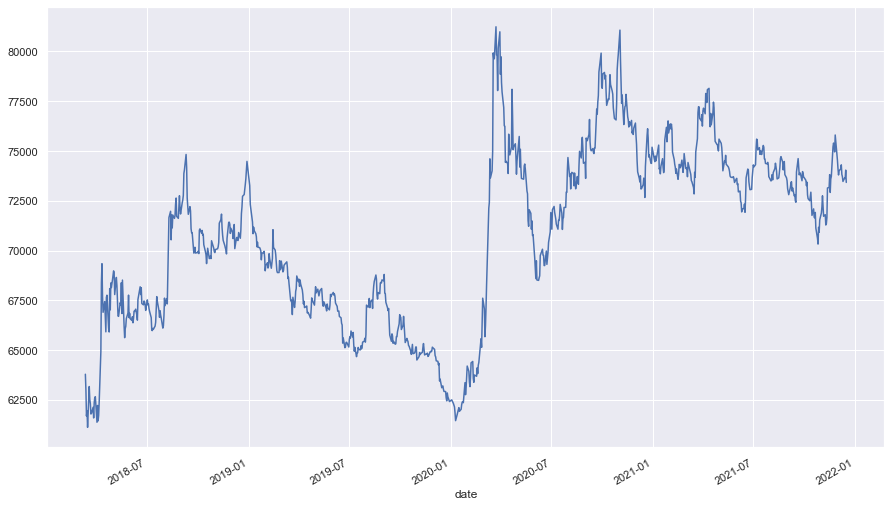

In [11]:
v.plot()

In [9]:
v.names_list

['Si-3.20',
 'Si-6.20',
 'Si-9.20',
 'Si-12.20',
 'Si-3.21',
 'Si-6.21',
 'Si-9.21',
 'Si-12.21']

<AxesSubplot:xlabel='date'>

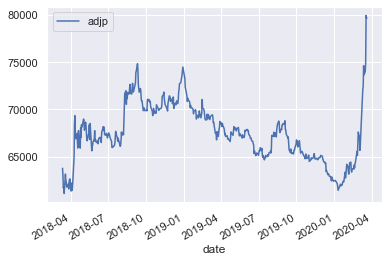

In [15]:
v.objects_dict['Si-3.20'].data.plot()

<AxesSubplot:xlabel='date'>

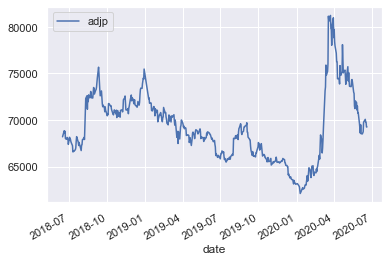

In [16]:
v.objects_dict['Si-6.20'].data.plot()

<AxesSubplot:xlabel='date'>

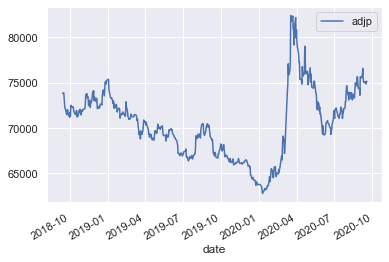

In [17]:
v.objects_dict['Si-9.20'].data.plot()

<AxesSubplot:xlabel='date'>

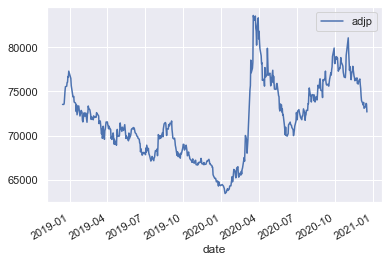

In [18]:
v.objects_dict['Si-12.20'].data.plot()